# Aim : This project focuses on predicting how efficiently a manufacturing team works each day using data like working hours, idle time, overtime, and number of workers. By studying these factors, we can find out what really affects a team’s performance. For example, too much idle time or frequent style changes may reduce productivity. The goal is to build a model that helps the company improve team efficiency and plan work better.

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer



In [33]:
df = pd.read_csv("manufacturing_data.csv")

In [34]:
df.shape


(1197, 15)

In [35]:
df.head()

,recordDate,fiscalQuarter,productionDept,dayOfWeek,team,plannedEfficiency,standardMinuteValue,workInProgress,overtimeMinutes,performanceBonus,idleMinutes,idleWorkers,styleChangeCount,workerCount,efficiencyScore
0,2/24/2015,Q4,Stitching Unit,Tuesday,Line-S1,0.6,22.53,708.0,5040,0,0.0,0,Minor Style Revision,42.0,0.268214
1,1/19/2015,Q3,Stitching Unit,Monday,Line-F3,0.8,11.41,1028.0,4380,50,0.0,0,No Style Change,31.0,0.800359
2,1/6/2015,Q1,Finishing & Quality,Tuesday,Line-C2,0.8,2.90,NaN,1440,0,0.0,0,No Style Change,8.0,0.681061
3,2/24/2015,Q4,Finishing & Quality,Tuesday,Line-S2,0.7,3.90,NaN,960,0,0.0,0,No Style Change,8.0,0.325000
4,1/4/2015,Q1,Finishing & Quality,Sunday,Line-C1,0.8,2.90,NaN,960,0,0.0,0,No Style Change,8.0,0.667604


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   recordDate           1197 non-null   object 
 1   fiscalQuarter        1197 non-null   object 
 2   productionDept       1197 non-null   object 
 3   dayOfWeek            1197 non-null   object 
 4   team                 1197 non-null   object 
 5   plannedEfficiency    1197 non-null   float64
 6   standardMinuteValue  1197 non-null   float64
 7   workInProgress       691 non-null    float64
 8   overtimeMinutes      1197 non-null   int64  
 9   performanceBonus     1197 non-null   int64  
 10  idleMinutes          1197 non-null   float64
 11  idleWorkers          1197 non-null   int64  
 12  styleChangeCount     1197 non-null   object 
 13  workerCount          1197 non-null   float64
 14  efficiencyScore      1197 non-null   float64
dtypes: float64(6), int64(3), object(6)
mem

In [37]:
df.isnull().sum()

,0
recordDate,0
fiscalQuarter,0
productionDept,0
dayOfWeek,0
team,0
plannedEfficiency,0
standardMinuteValue,0
workInProgress,506
overtimeMinutes,0
performanceBonus,0


In [38]:
df["recordDate"]=pd.to_datetime(df["recordDate"])
df=df.set_index("recordDate")

In [39]:
df.head()

,fiscalQuarter,productionDept,dayOfWeek,team,plannedEfficiency,standardMinuteValue,workInProgress,overtimeMinutes,performanceBonus,idleMinutes,idleWorkers,styleChangeCount,workerCount,efficiencyScore
recordDate,,,,,,,,,,,,,,
2015-02-24,Q4,Stitching Unit,Tuesday,Line-S1,0.6,22.53,708.0,5040,0,0.0,0,Minor Style Revision,42.0,0.268214
2015-01-19,Q3,Stitching Unit,Monday,Line-F3,0.8,11.41,1028.0,4380,50,0.0,0,No Style Change,31.0,0.800359
2015-01-06,Q1,Finishing & Quality,Tuesday,Line-C2,0.8,2.90,NaN,1440,0,0.0,0,No Style Change,8.0,0.681061
2015-02-24,Q4,Finishing & Quality,Tuesday,Line-S2,0.7,3.90,NaN,960,0,0.0,0,No Style Change,8.0,0.325000
2015-01-04,Q1,Finishing & Quality,Sunday,Line-C1,0.8,2.90,NaN,960,0,0.0,0,No Style Change,8.0,0.667604


# Univariate analysis

In [40]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns

num_cols


Index(['plannedEfficiency', 'standardMinuteValue', 'workInProgress',
       'overtimeMinutes', 'performanceBonus', 'idleMinutes', 'idleWorkers',
       'workerCount', 'efficiencyScore'],
      dtype='object')

In [41]:
cat_cols = df.select_dtypes(include=['object', 'category']).columns

cat_cols


Index(['fiscalQuarter', 'productionDept', 'dayOfWeek', 'team',
       'styleChangeCount'],
      dtype='object')

In [42]:
display(df[num_cols].describe().T)

,count,mean,std,min,25%,50%,75%,max
plannedEfficiency,1197.0,0.729632,0.097891,0.070000,0.700000,0.750000,0.800000,0.800000
standardMinuteValue,1197.0,15.062172,10.943219,2.900000,3.940000,15.260000,24.260000,54.560000
workInProgress,691.0,1190.465991,1837.455001,7.000000,774.500000,1039.000000,1252.500000,23122.000000
overtimeMinutes,1197.0,4567.460317,3348.823563,0.000000,1440.000000,3960.000000,6960.000000,25920.000000
performanceBonus,1197.0,38.210526,160.182643,0.000000,0.000000,0.000000,50.000000,3600.000000
idleMinutes,1197.0,0.730159,12.709757,0.000000,0.000000,0.000000,0.000000,300.000000
idleWorkers,1197.0,0.369256,3.268987,0.000000,0.000000,0.000000,0.000000,45.000000
workerCount,1197.0,34.609858,22.197687,2.000000,9.000000,34.000000,57.000000,89.000000
efficiencyScore,1197.0,0.735091,0.174488,0.233705,0.650307,0.773333,0.850253,1.120437


#  these have Positive correlations with conversion

efficiencyScore > planned efficiency , that's good in performance

also mean < median which means slightly left skewed, majority performs above average

---
OvertimeMinutes

Mean > Median → right-skewed — a few teams doing extreme overtime.

use : If we relate overtime with efficiencyScore, we can discover whether working extra hours actually improves output — or if it just causes fatigue.

---

Performance Bonus

Mean ≫ Median → heavily right-skewed (most employees get 0, few get large bonuses)




# these have negative correlations with conversion

Idle time

Mean ≫ Median → highly right-skewed (most sessions have no idle time, few with long idleness).

use : Predict idle patterns → cut down wasted hours → direct improvement in productivity.

---
Idle workers

Mean ≫ Median → right-skewed again.

Most of the time, no workers are idle, but sometimes entire groups wait — likely due to dependency delays.
This aligns with spikes in idleMinutes and high WIP.


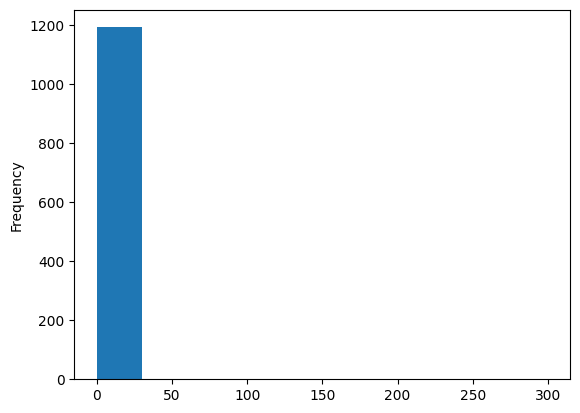

In [43]:
df['idleMinutes'].plot(kind='hist')
plt.show()

On most days, workers are busy and efficient, with only small idle breaks — maybe for tea, machine setup, or material waiting.

But sometimes, due to machine breakdowns, raw material delays, or power cuts, the entire team could be idle for a long stretch.

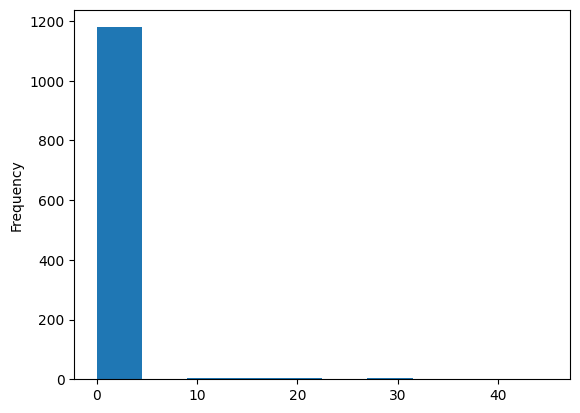

In [44]:
df['idleWorkers'].plot(kind='hist')
plt.show()

In [45]:
dept = df.productionDept.value_counts().reset_index()
dept.rename(columns = {'productionDept':'department', 'count':'total_num'},inplace=True)
dept

,department,total_num
0,Stitching Unit,691
1,Finishing & Quality,257
2,Finishing & Quality,249


In [47]:
df['productionDept'] = df['productionDept'].str.replace(' ','')
df['productionDept'].unique()

array(['StitchingUnit', 'Finishing&Quality'], dtype=object)

In [48]:
df['productionDept'] = df['productionDept'].str.strip()
df['productionDept'].value_counts()


,count
productionDept,
StitchingUnit,691
Finishing&Quality,506


In [49]:
df.drop(['workInProgress', 'idleWorkers', 'idleMinutes'], axis=1, inplace=True)

In [54]:
quarters = df['fiscalQuarter'].unique()

In [55]:
quarters

array(['Q4', 'Q3', 'Q1', 'Q2', 'Q5'], dtype=object)

# univariate analysis on numerical columns

In [58]:
import plotly.express as px
import pandas as pd

num_cols = df.select_dtypes(include=['number']).columns

for col in num_cols:
    fig = px.histogram(
        df,
        x=col,
        nbins=20,
        template='plotly_dark',
        title=f"Distribution of {col}"
    )
    fig.update_layout(title_x=0.5)
    fig.show()

    ## Most data points are clustered between 0.7 and 0.8, meaning that most teams planned their work to achieve around 70–80% efficiency.
    ## Most of the tasks have a low SMV value (below 5 minutes) — meaning these are quick and simple operations such as stitching small parts, labeling, or basic assembly.
    ## there must be teams which have low worker count and teams with high worker count


# univariate analysis on categorical columns

In [59]:
cat_cols

Index(['fiscalQuarter', 'productionDept', 'dayOfWeek', 'team',
       'styleChangeCount'],
      dtype='object')

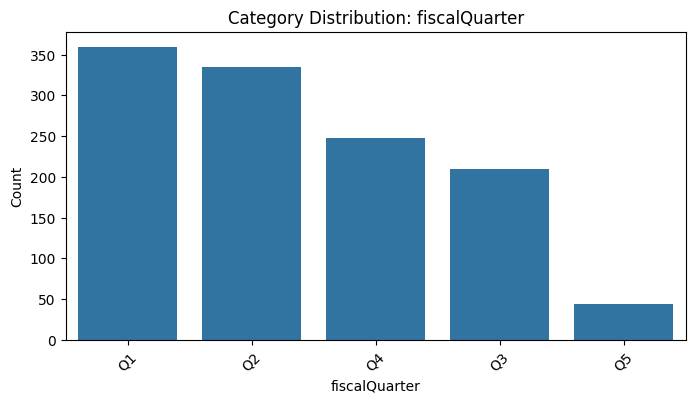

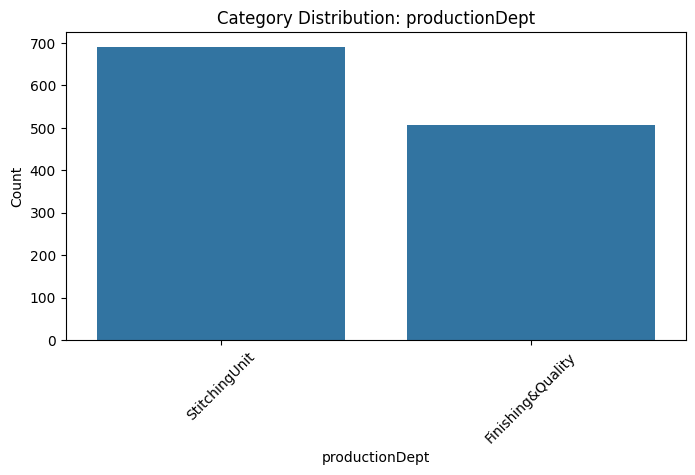

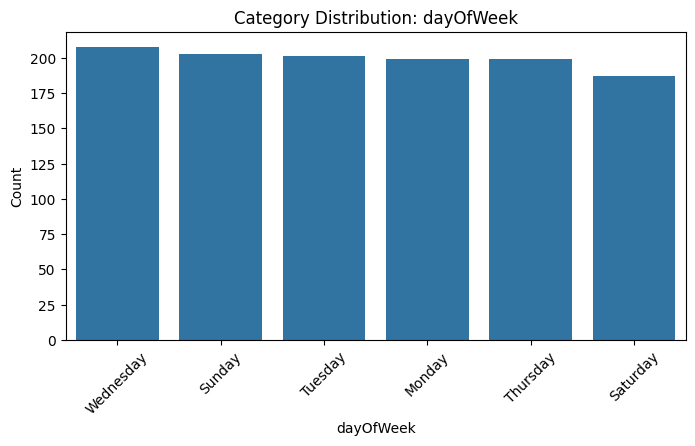

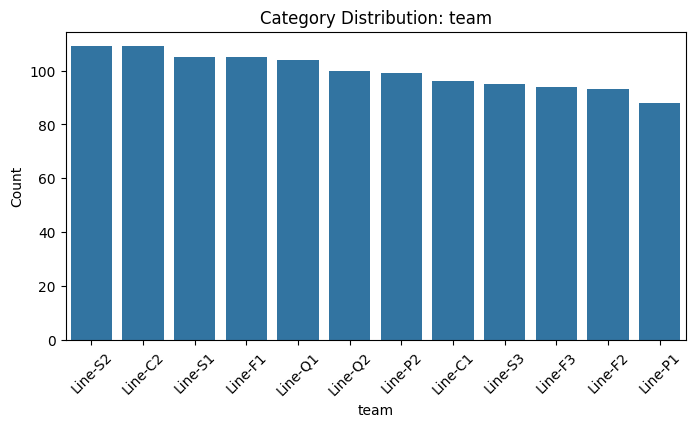

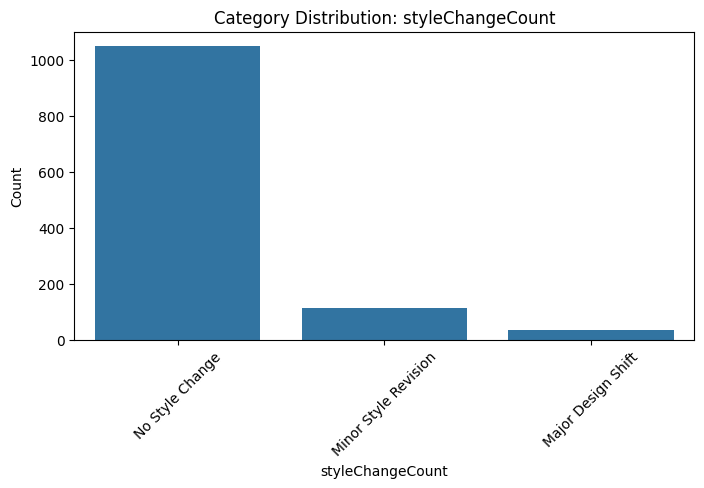

In [60]:
for col in cat_cols:
    plt.figure(figsize=(8,4))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.title(f"Category Distribution: {col}", fontsize=12)
    plt.xticks(rotation=45)
    plt.ylabel("Count")
    plt.show()


# quarters wrt to number of workers and performance bonus

In [63]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Workers per Quarter", "Performance Bonus per Quarter")
)
x = df['fiscalQuarter']
y1 = df['workerCount']
y2 = df['performanceBonus']

fig.add_trace(go.Bar(x=x, y=y1, name="Worker Count", marker_color='skyblue'), row=1, col=1)
fig.add_trace(go.Bar(x=x, y=y2, name="Performance Bonus", marker_color='orange'), row=1, col=2)

fig.update_layout(
    title='Number of Workers and Incentive Paid per Quarter',
    title_x=0.5,
    showlegend=False,
    template='plotly_dark',
    height=500,
    width=1000
)


fig.update_xaxes(title_text="Fiscal Quarter", row=1, col=1)
fig.update_yaxes(title_text="Number of Workers", row=1, col=1)
fig.update_xaxes(title_text="Fiscal Quarter", row=1, col=2)
fig.update_yaxes(title_text="Performance Bonus", row=1, col=2)

fig.show()


# Actual vs targeted productivity

In [65]:
t_vs_a = ['plannedEfficiency', 'efficiencyScore']
df[t_vs_a].describe()

,plannedEfficiency,efficiencyScore
count,1197.000000,1197.000000
mean,0.729632,0.735091
std,0.097891,0.174488
min,0.070000,0.233705
25%,0.700000,0.650307
50%,0.750000,0.773333
75%,0.800000,0.850253
max,0.800000,1.120437


* actual productivity fluctuates more, implying external factors (like worker performance, delays, material availability, or workload spikes).

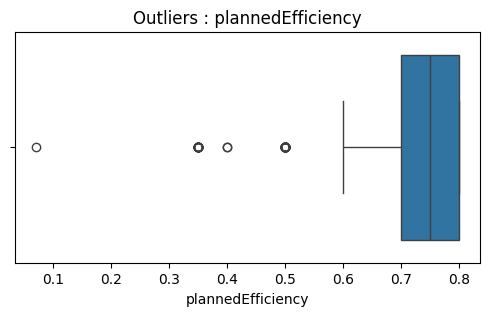

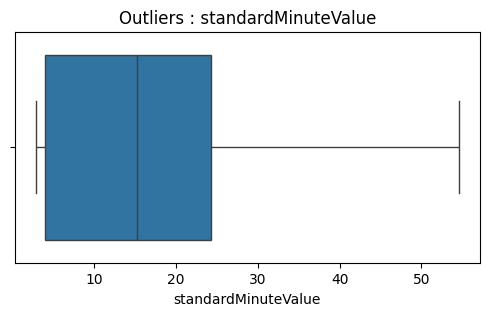

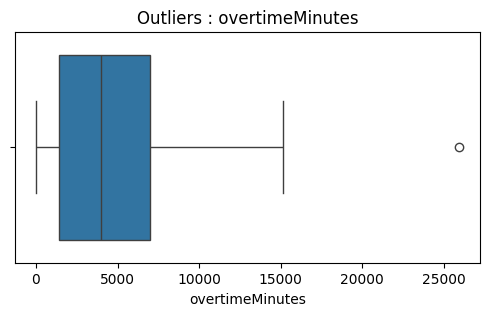

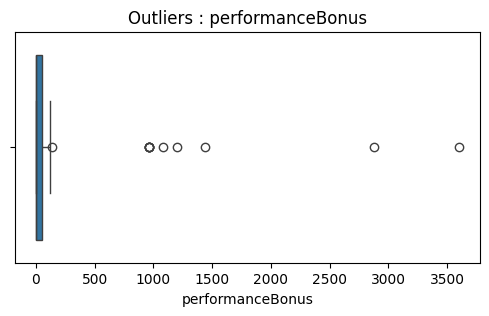

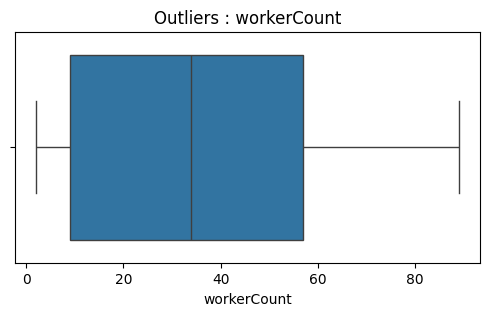

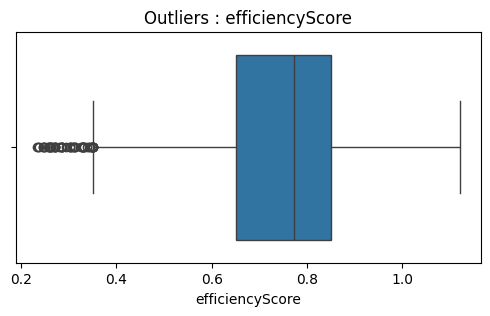

In [66]:
# outliers using box plot

for col in num_cols:
    plt.figure(figsize=(6,3))
    sns.boxplot(x=df[col])
    plt.title(f"Outliers : {col}", fontsize=12)
    plt.show()

The boxplots clearly show that standardMinuteValue, workInProgress, overtimeMinutes, performanceBonus, idleMinutes, and idleWorkers have a significant number of outliers. workerCount also has some outliers.

In [70]:
# bivariate

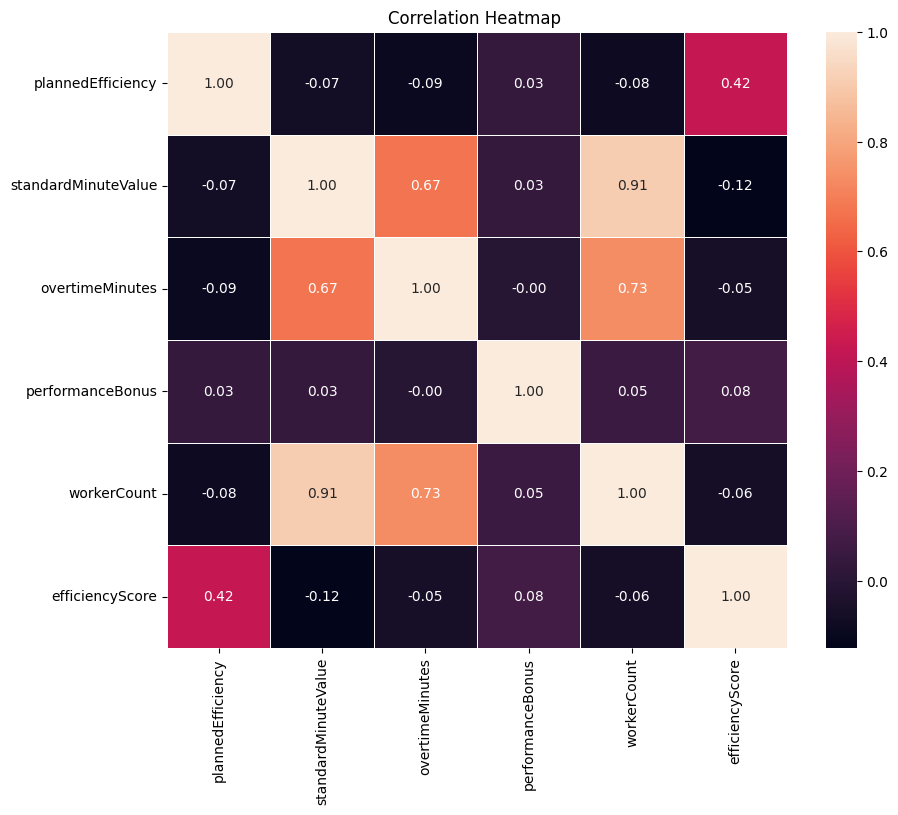

In [71]:
## numerical-numerical

corr_matrix = df[num_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True,  fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap ")
plt.show()

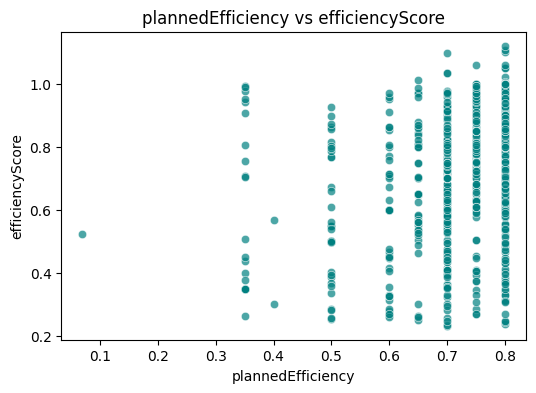

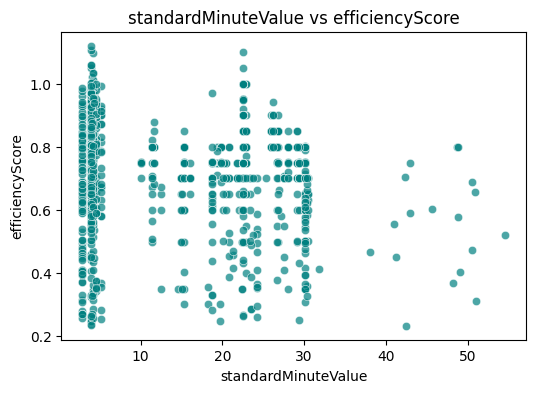

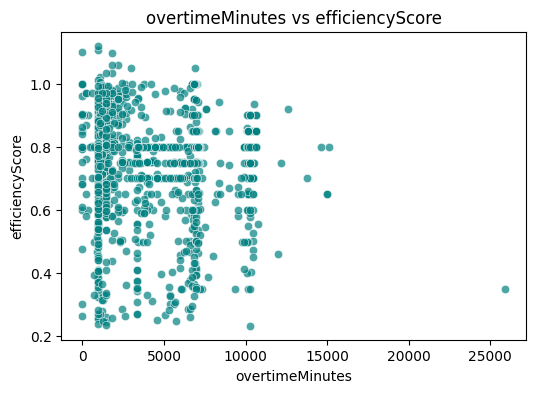

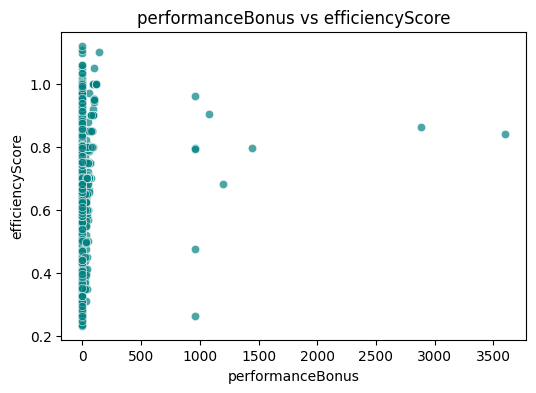

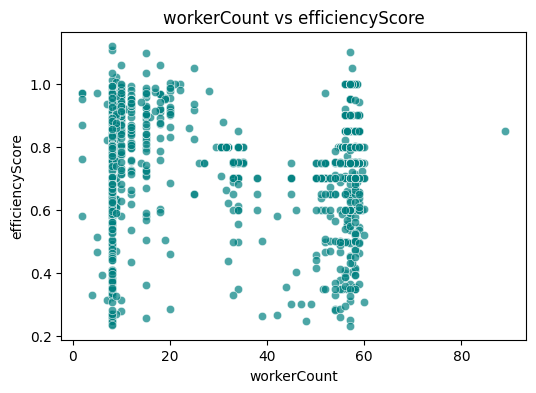

In [72]:
# scatter plot for target variable

target = 'efficiencyScore'
if target in df.columns:
    for col in num_cols:
        if col != target:
            plt.figure(figsize=(6,4))
            sns.scatterplot(x=df[col], y=df[target], alpha=0.7, color='teal')
            plt.title(f"{col} vs {target}")
            plt.xlabel(col)
            plt.ylabel(target)
            plt.show()

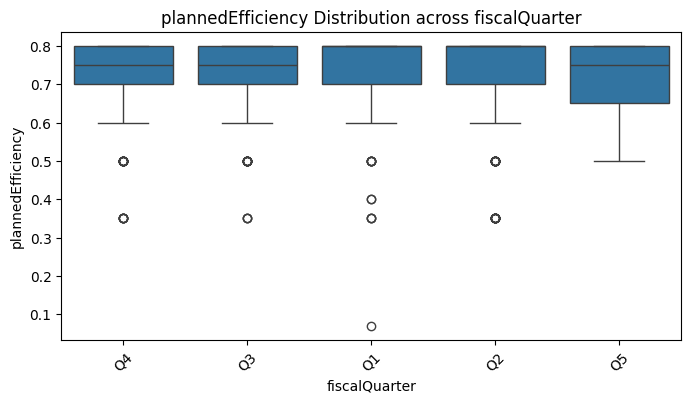

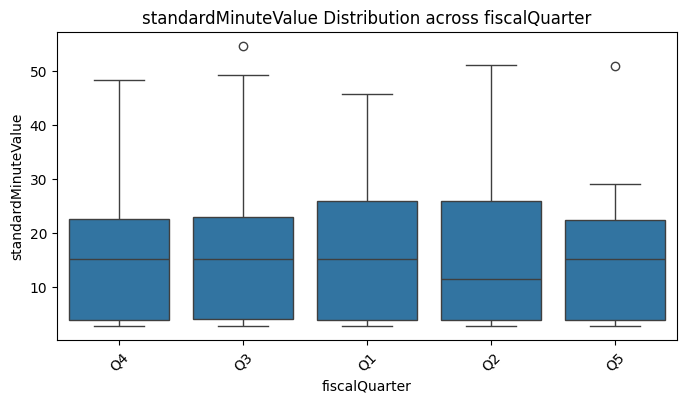

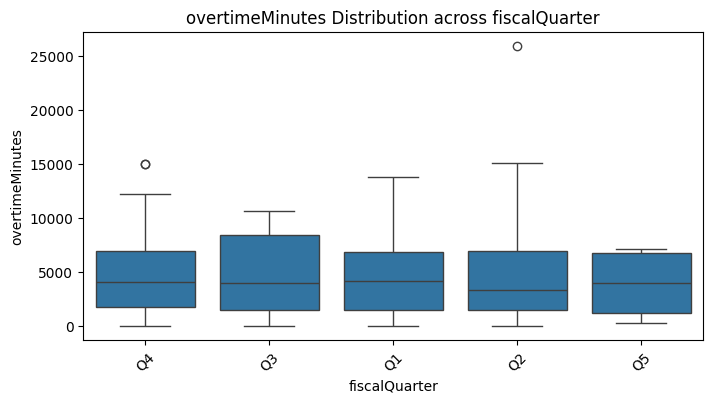

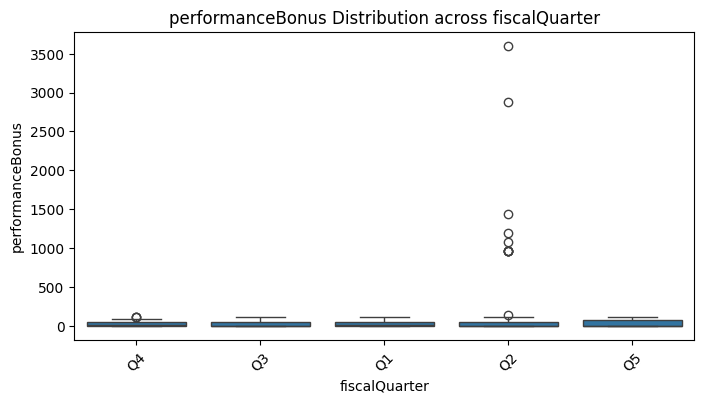

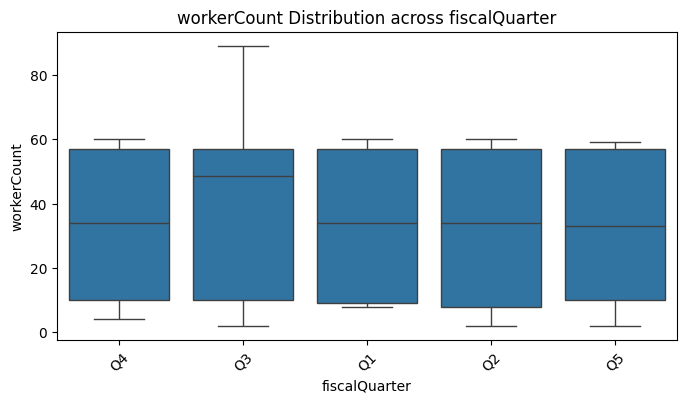

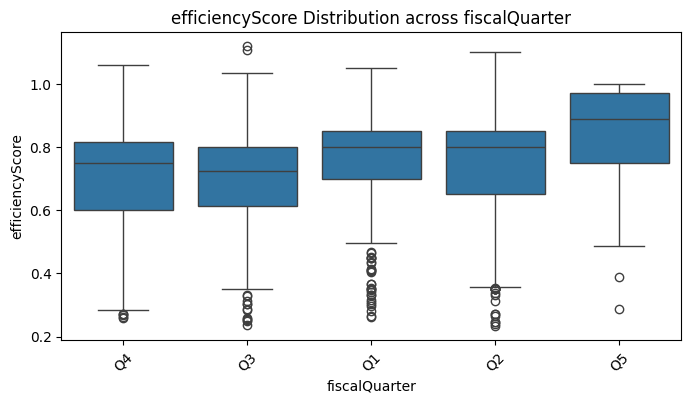

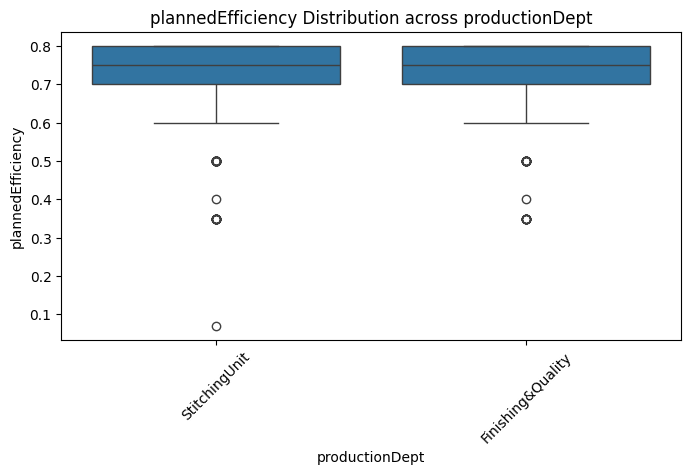

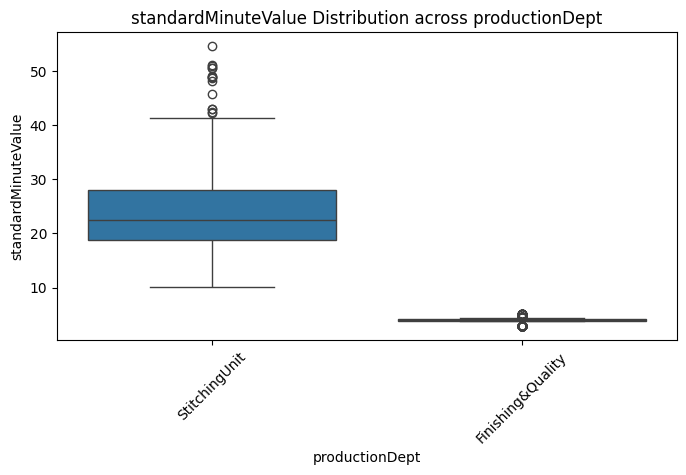

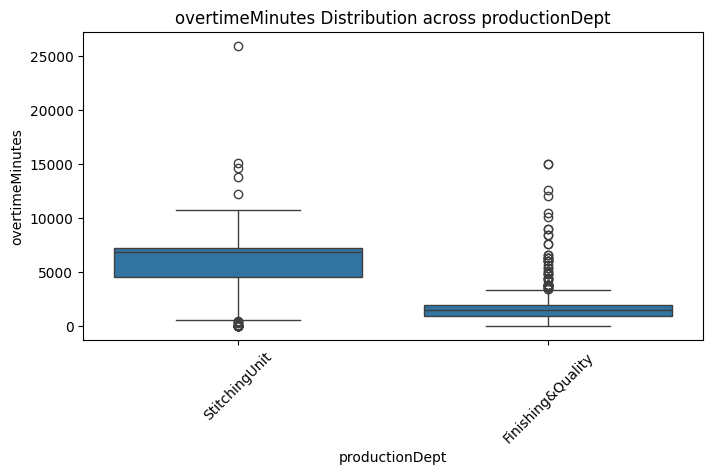

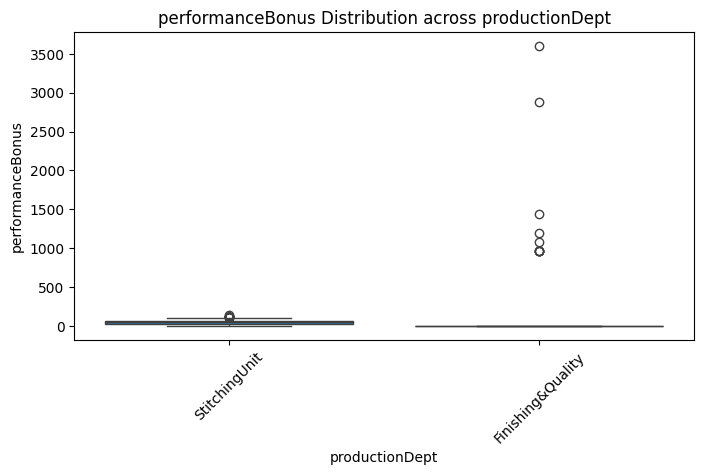

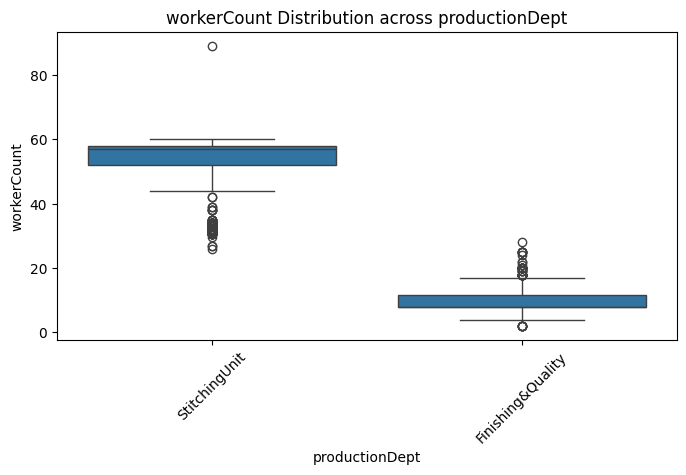

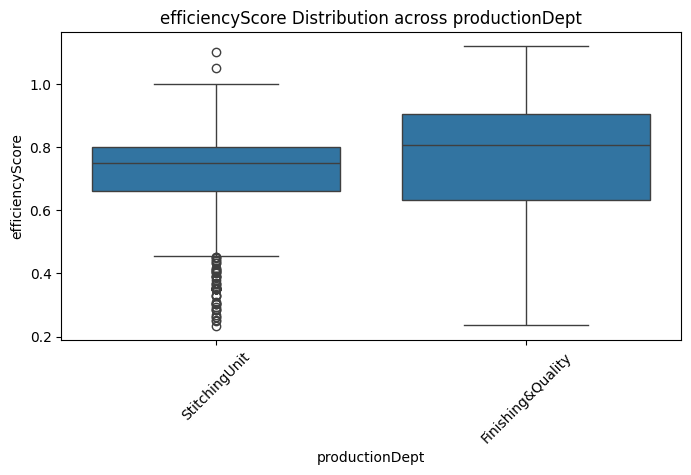

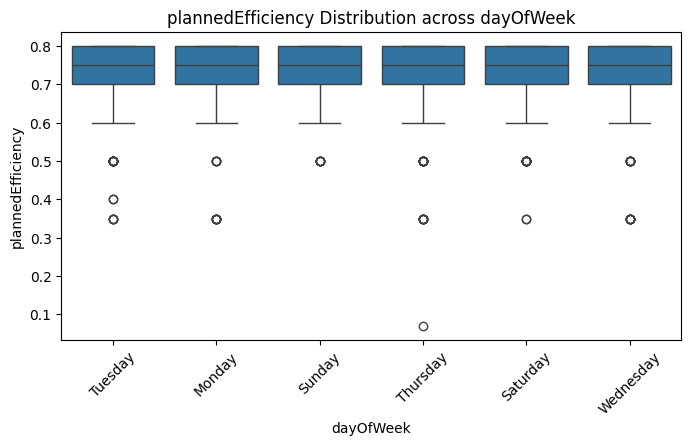

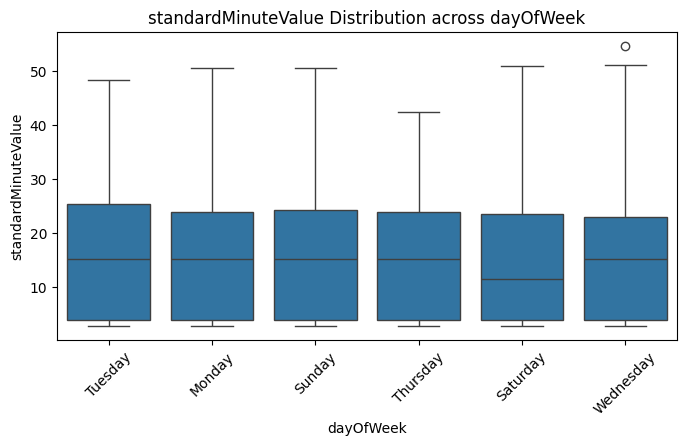

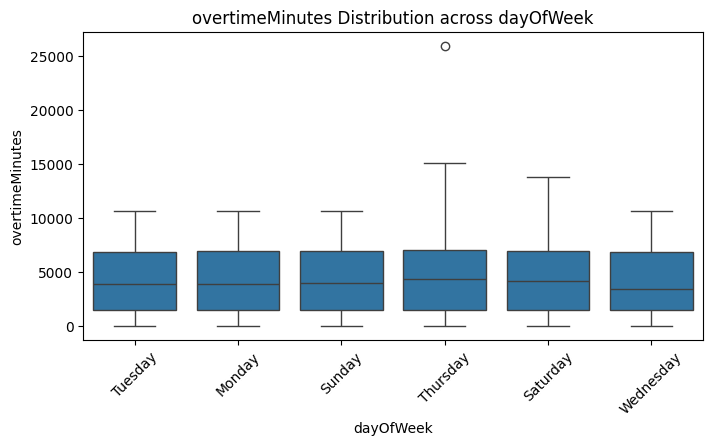

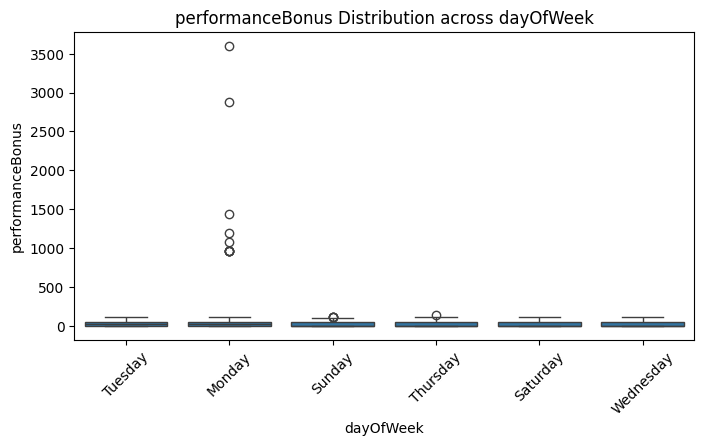

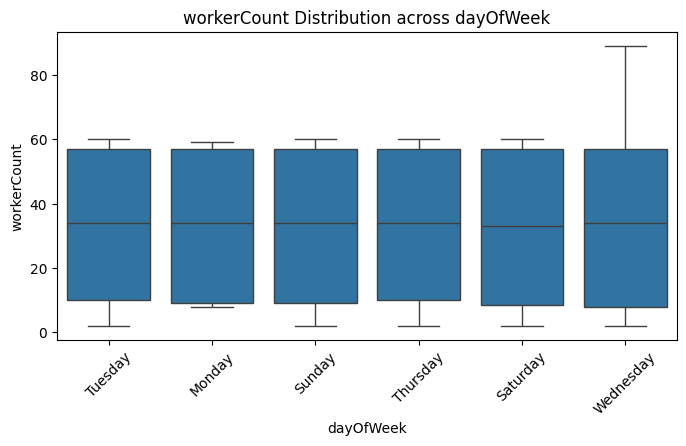

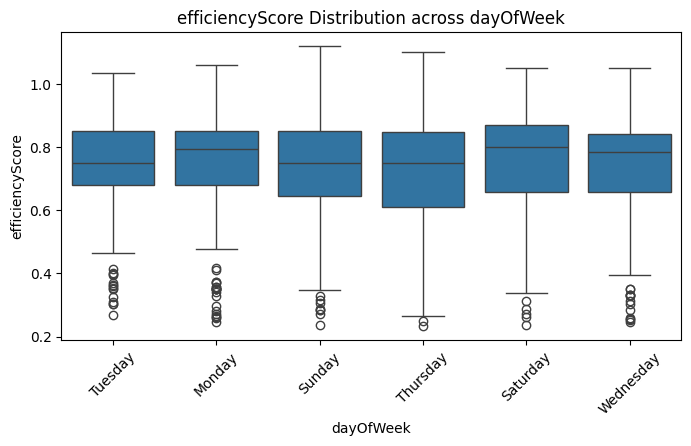

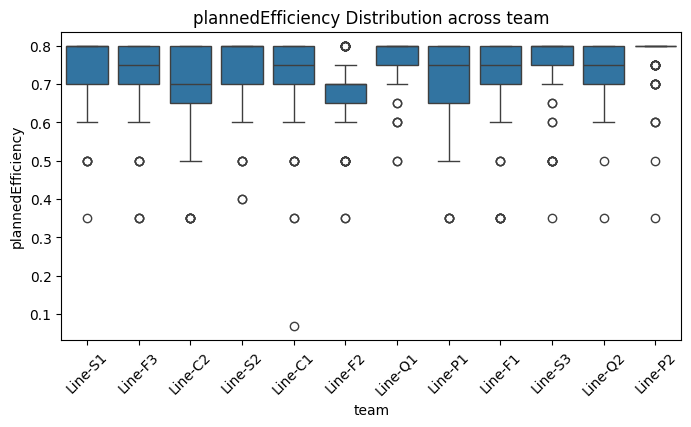

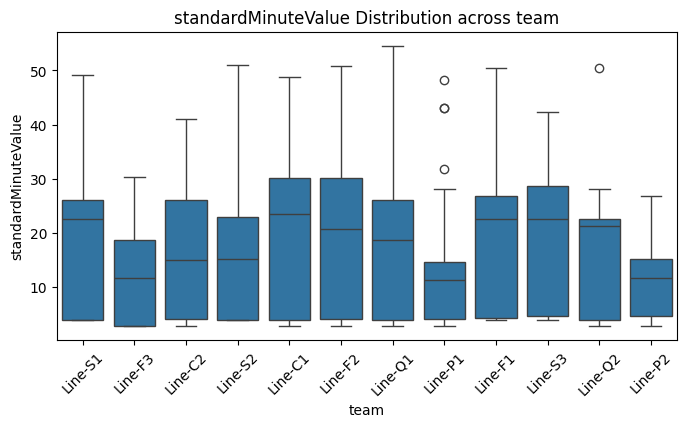

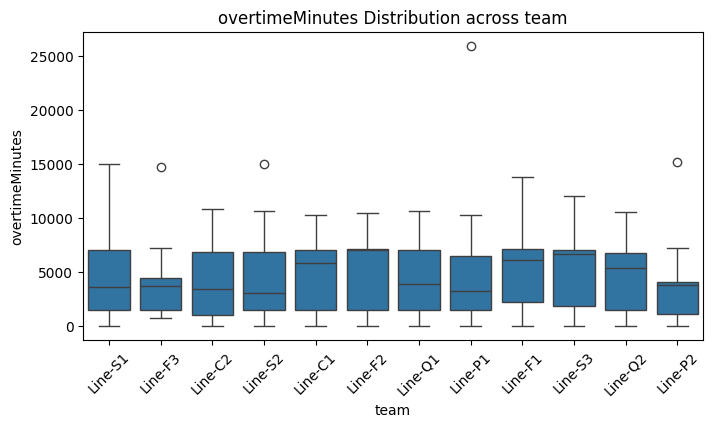

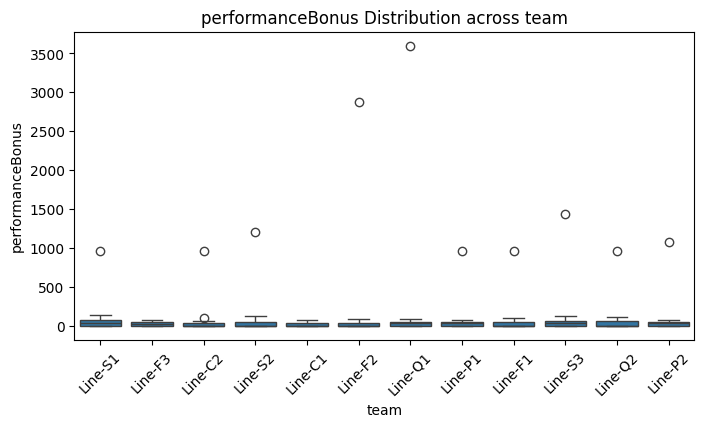

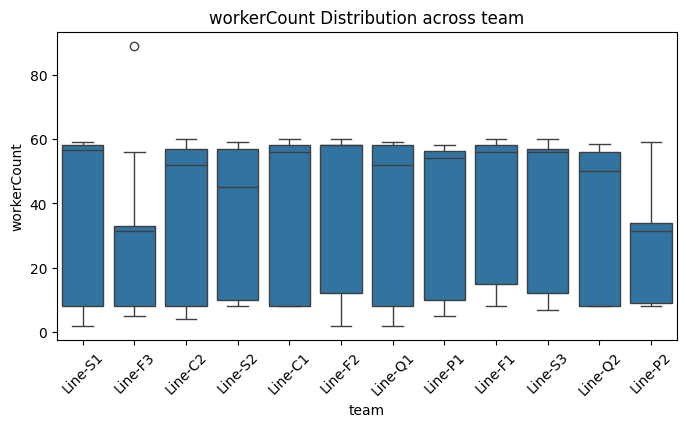

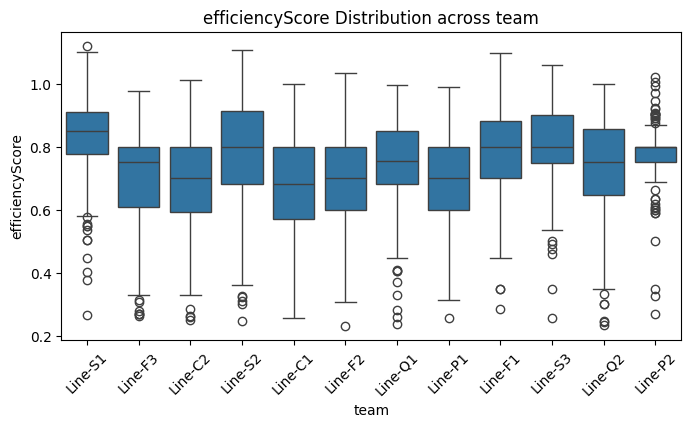

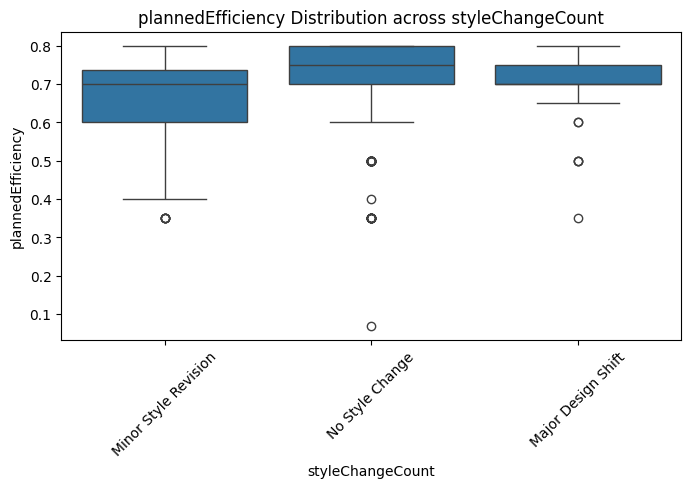

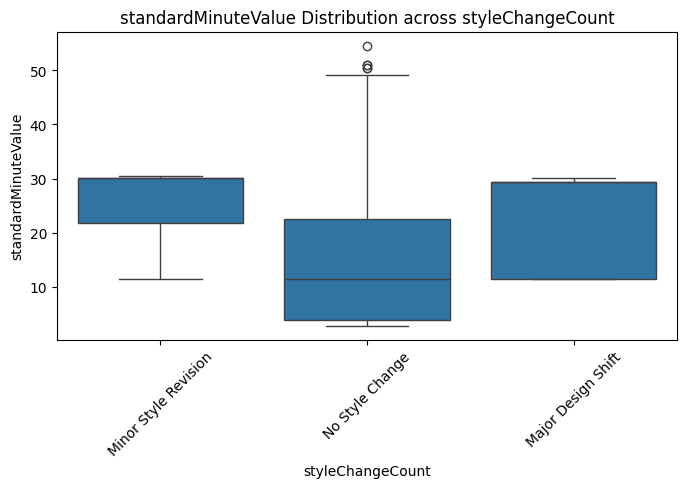

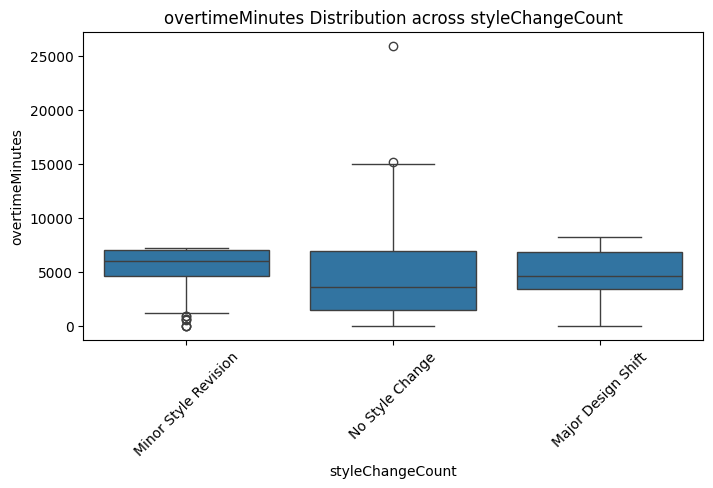

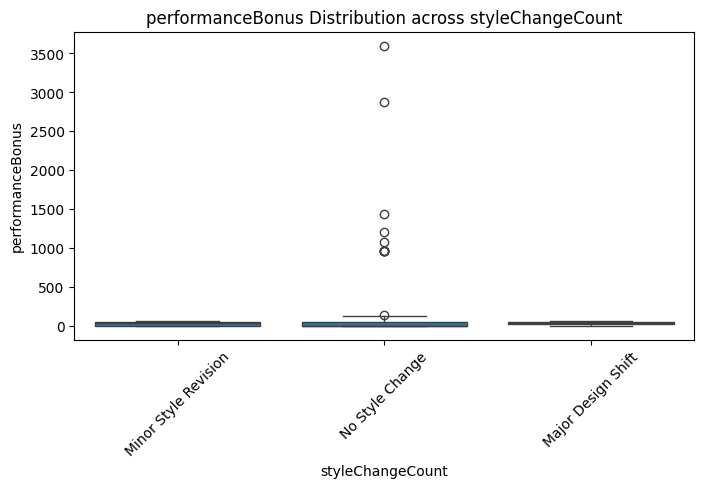

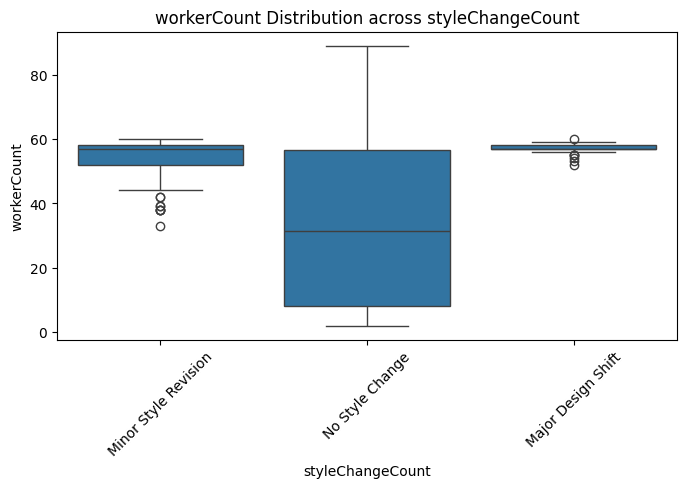

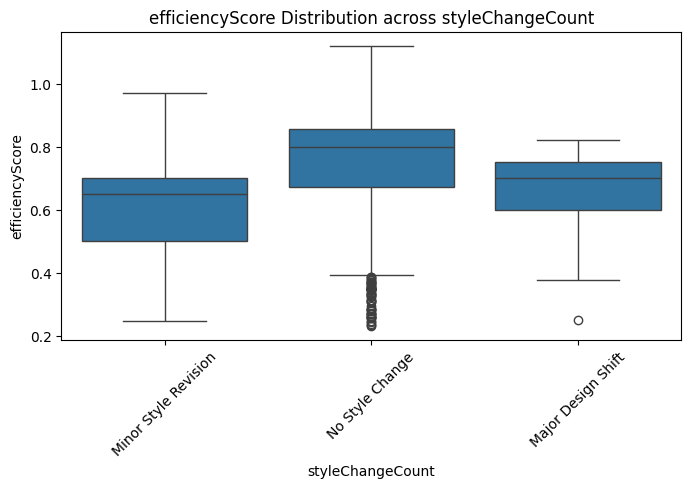

In [74]:
## numerical - categorical

for col in cat_cols:
    for num in num_cols:
        plt.figure(figsize=(8,4))
        sns.boxplot(data=df, x=col, y=num)
        plt.title(f"{num} Distribution across {col}")
        plt.xticks(rotation=45)
        plt.show()

# Insights:

Departments have different vibes: When we looked at numbers like how much time a task should take (standardMinuteValue) or how many people were on a job (workerCount), the boxes for the "Stitching Unit" were generally higher and more spread out than the boxes for other departments. This is like saying the Stitching Unit seems to handle the bigger, more involved tasks. We also saw that how "efficient" things were (efficiencyScore) seemed to wiggle around differently depending on the department.



Some days might be busier: For things like overtimeMinutes, we might see the boxes looking a bit higher on certain days of the week. It's like some days just naturally require a bit more hustle to get things done.

Teams are like different sports teams: This is where we saw some of the clearest differences! When we looked at the efficiencyScore boxes for each team, some teams consistently had their boxes higher up (meaning they were more efficient) and the boxes were skinnier (meaning their performance was more consistent). Other teams had lower boxes or wider boxes, showing they might be less efficient or have more ups and downs in their performance. This tells us that the team itself really matters! We could also see which teams tended to have more overtime or more idle time by looking at those specific boxplots.

Style changes can cause bumps in the road: The boxplots comparing the numbers based on whether there was a style change or not could show us that when there was a change, things like efficiency might dip, or the amount of unfinished work (workInProgress) might go up. It's like a speed bump in the manufacturing process.

# Handling Outliers

In [75]:
import pandas as pd

numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

outlier_summary = pd.DataFrame(columns=['Lower Outliers', 'Upper Outliers', 'Total Outliers'])

# Detect outliers using IQR
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR


    lower_outliers = (df[col] < lower_limit).sum()
    upper_outliers = (df[col] > upper_limit).sum()
    total_outliers = lower_outliers + upper_outliers

    outlier_summary.loc[col] = [lower_outliers, upper_outliers, total_outliers]

print("Outlier Counts (Before Capping):")
display(outlier_summary.sort_values(by='Total Outliers', ascending=False))


Outlier Counts (Before Capping):


,Lower Outliers,Upper Outliers,Total Outliers
plannedEfficiency,79,0,79
efficiencyScore,54,0,54
performanceBonus,0,11,11
overtimeMinutes,0,1,1
standardMinuteValue,0,0,0
workerCount,0,0,0


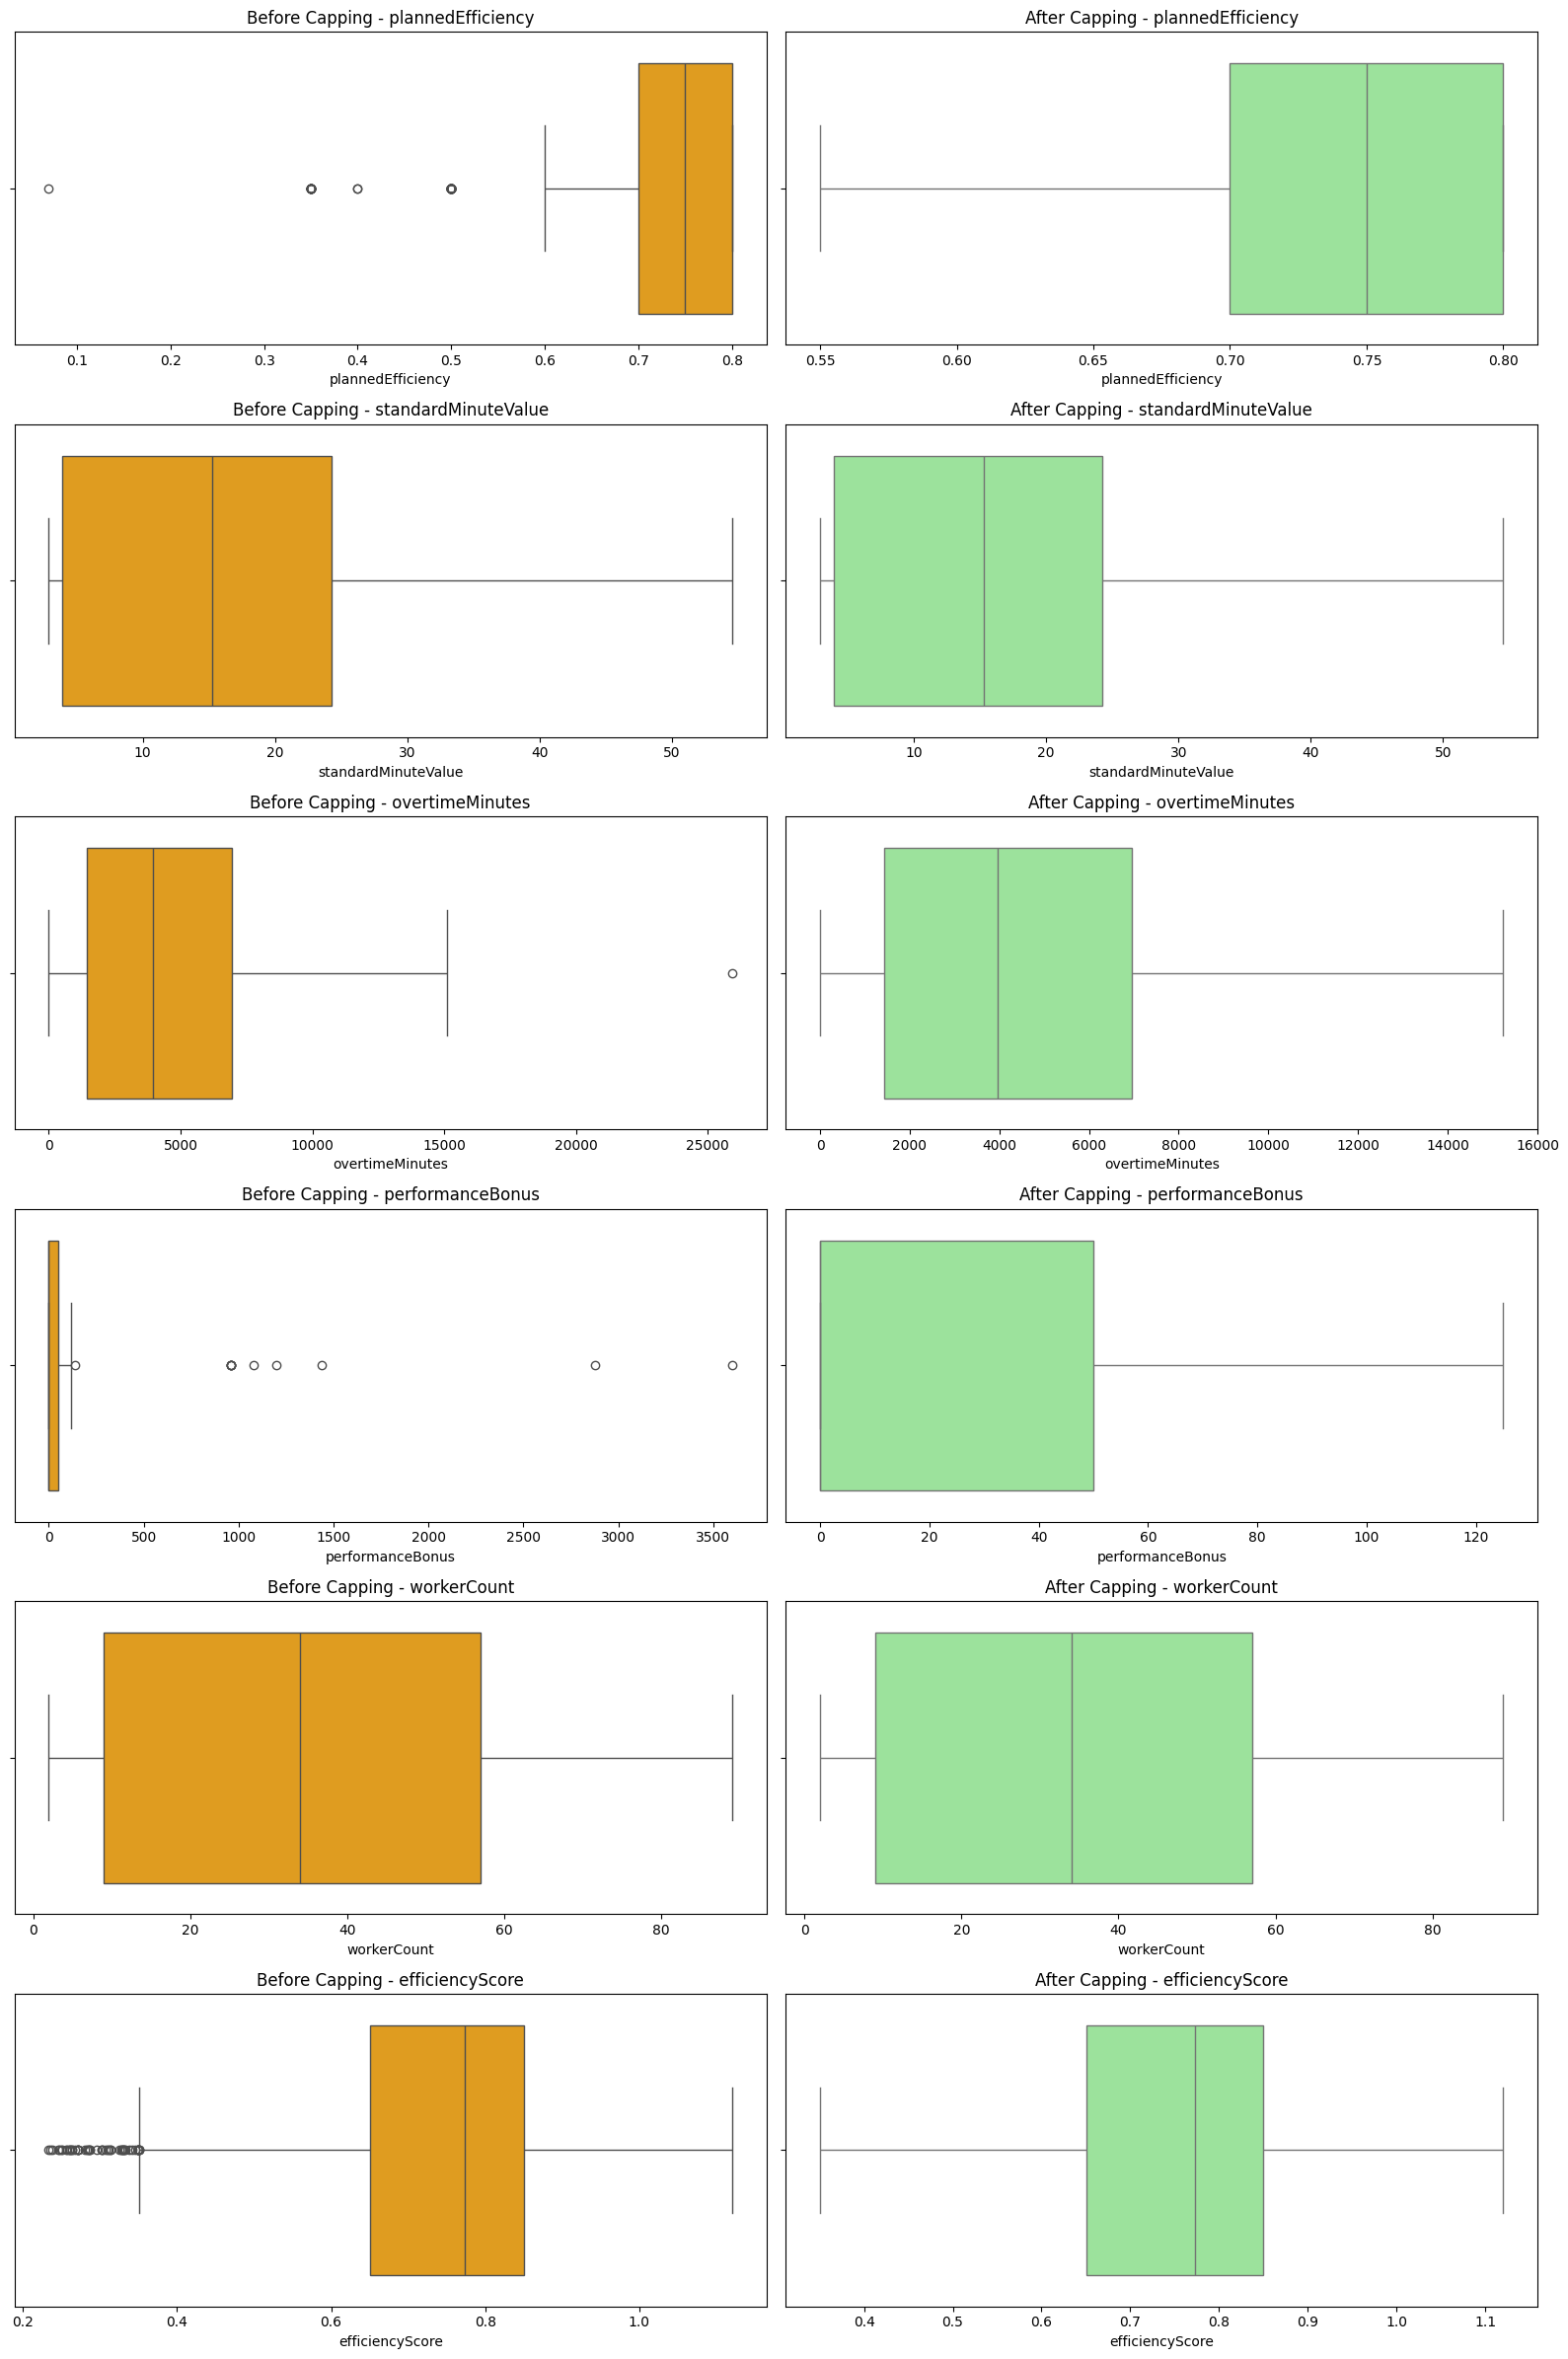

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Select only numerical columns
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Create a copy for capping
df_capped = df.copy()

# Plot setup
plt.figure(figsize=(16, len(numeric_cols)*4))

# Loop through each numeric column
for i, col in enumerate(numeric_cols):
    # Calculate IQR
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    # Cap the outliers
    df_capped[col] = df[col].clip(lower=lower_limit, upper=upper_limit)

    # Plot before and after side by side
    plt.subplot(len(numeric_cols), 2, 2*i + 1)
    sns.boxplot(x=df[col], color='orange')
    plt.title(f"Before Capping - {col}")

    plt.subplot(len(numeric_cols), 2, 2*i + 2)
    sns.boxplot(x=df_capped[col], color='lightgreen')
    plt.title(f"After Capping - {col}")

plt.tight_layout()
plt.show()


# feature scaling

# Preprocessing Pipeline with Imputer, Scaler, and One-Hot Encoder

In [77]:
df.shape

(1197, 11)

In [78]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

In [79]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['fiscalQuarter','productionDept','dayOfWeek', 'team', 'styleChangeCount']),
        ('num', StandardScaler(), ['plannedEfficiency', 'standardMinuteValue', 'overtimeMinutes', 'performanceBonus', 'workerCount'])

    ],
   remainder='passthrough'
)

In [83]:

X = df_capped.drop(['efficiencyScore'], axis=1)
y = df_capped['efficiencyScore']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (957, 10)
X_test shape: (240, 10)
y_train shape: (957,)
y_test shape: (240,)


In [84]:
preprocessor.fit_transform(X_train)
preprocessor.get_feature_names_out()

array(['cat__fiscalQuarter_Q1', 'cat__fiscalQuarter_Q2',
       'cat__fiscalQuarter_Q3', 'cat__fiscalQuarter_Q4',
       'cat__fiscalQuarter_Q5', 'cat__productionDept_Finishing&Quality',
       'cat__productionDept_StitchingUnit', 'cat__dayOfWeek_Monday',
       'cat__dayOfWeek_Saturday', 'cat__dayOfWeek_Sunday',
       'cat__dayOfWeek_Thursday', 'cat__dayOfWeek_Tuesday',
       'cat__dayOfWeek_Wednesday', 'cat__team_Line-C1',
       'cat__team_Line-C2', 'cat__team_Line-F1', 'cat__team_Line-F2',
       'cat__team_Line-F3', 'cat__team_Line-P1', 'cat__team_Line-P2',
       'cat__team_Line-Q1', 'cat__team_Line-Q2', 'cat__team_Line-S1',
       'cat__team_Line-S2', 'cat__team_Line-S3',
       'cat__styleChangeCount_Major Design Shift',
       'cat__styleChangeCount_Minor Style Revision',
       'cat__styleChangeCount_No Style Change', 'num__plannedEfficiency',
       'num__standardMinuteValue', 'num__overtimeMinutes',
       'num__performanceBonus', 'num__workerCount'], dtype=object)

In [85]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [86]:
X_train_processed_df = pd.DataFrame(X_train_processed, columns=preprocessor.get_feature_names_out())
X_test_processed_df = pd.DataFrame(X_test_processed, columns=preprocessor.get_feature_names_out())

In [87]:
X_train_processed_df.head()

,cat__fiscalQuarter_Q1,cat__fiscalQuarter_Q2,cat__fiscalQuarter_Q3,cat__fiscalQuarter_Q4,cat__fiscalQuarter_Q5,cat__productionDept_Finishing&Quality,cat__productionDept_StitchingUnit,cat__dayOfWeek_Monday,cat__dayOfWeek_Saturday,cat__dayOfWeek_Sunday,...,cat__team_Line-S2,cat__team_Line-S3,cat__styleChangeCount_Major Design Shift,cat__styleChangeCount_Minor Style Revision,cat__styleChangeCount_No Style Change,num__plannedEfficiency,num__standardMinuteValue,num__overtimeMinutes,num__performanceBonus,num__workerCount
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.826181,-1.114724,-0.935603,-0.842312,-1.188932
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,-0.508258,0.485300,1.797922,0.739875,1.046843
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.826181,0.436842,0.576947,-0.842312,0.912696
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.158961,1.187482,1.825257,0.581656,1.069200
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,-2.509918,-0.000193,-1.154285,-0.114506,0.778550


In [88]:
X_train_processed.shape

(957, 33)

* before it was (957,10)

# statistics



In [92]:

DISCRETE_COLS = [
    'fiscalQuarter',
    'productionDept',
    'dayOfWeek',
    'team',
    'styleChangeCount',

    'workerCount'
]

CONTINUOUS_COLS = [
    'plannedEfficiency',
    'standardMinuteValue',
    'overtimeMinutes',
    'performanceBonus',

    'efficiencyScore'
]

def plot_distributions(df, discrete_cols, continuous_cols):
    # --- PMF + CDF for Discrete Variables ---
    for col in discrete_cols:
        data = df[col].dropna()
        if data.empty:
            continue

        pmf = data.value_counts(normalize=True).sort_index()
        cdf = pmf.cumsum()

        # Keep top 20 categories if too many
        if len(pmf) > 20:
            pmf = pmf.nlargest(20)
            cdf = cdf.loc[pmf.index]

        plt.figure(figsize=(12, 5))
        plt.suptitle(f'Discrete Feature: {col}', fontsize=16)

        # PMF
        plt.subplot(1, 2, 1)
        pmf.plot(kind='bar', color='steelblue')
        plt.title('Probability of Each Value (PMF)')
        plt.xlabel(col)
        plt.ylabel('Probability')
        plt.xticks(rotation=45, ha='right')

        # CDF
        plt.subplot(1, 2, 2)
        plt.step(cdf.index, cdf.values, where='post', color='green', marker='o', linestyle='-')
        plt.title('Cumulative Probability (CDF)')
        plt.xlabel(col)
        plt.ylabel('Cumulative Probability')
        plt.ylim(0, 1.05)

        plt.tight_layout()
        plt.show()

    # --- PDF + CDF for Continuous Variables ---
    for col in continuous_cols:
        data = df[col].dropna()
        if data.empty:
            continue

        plt.figure(figsize=(12, 5))
        plt.suptitle(f'Continuous Feature: {col}', fontsize=16)

        # PDF
        plt.subplot(1, 2, 1)
        sns.kdeplot(data, fill=True, color='purple')
        plt.title('Density of Values (PDF)')
        plt.xlabel(col)
        plt.ylabel('Density')

        # CDF
        sorted_data = np.sort(data)
        cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
        plt.subplot(1, 2, 2)
        plt.step(sorted_data, cdf, where='post', color='orange', marker='o', linestyle='-')
        plt.title('Cumulative Probability (CDF)')
        plt.xlabel(col)
        plt.ylabel('Cumulative Probability')
        plt.ylim(0, 1.05)

        plt.tight_layout()
        plt.show()


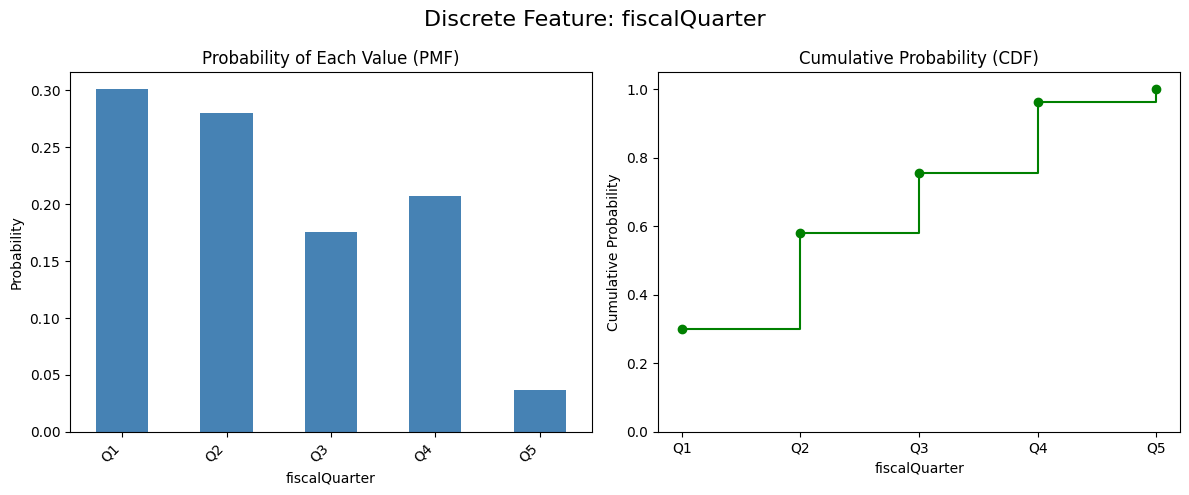

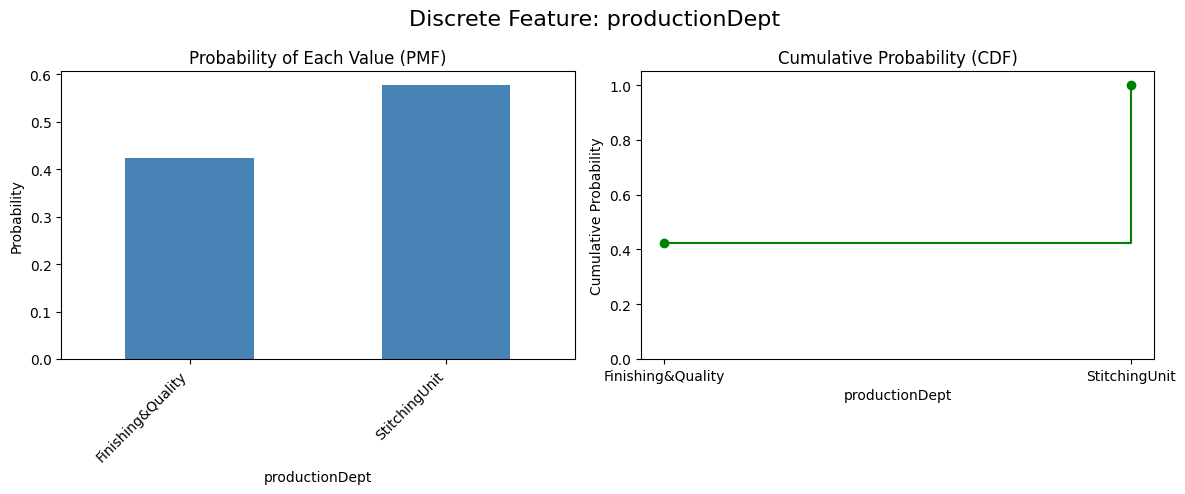

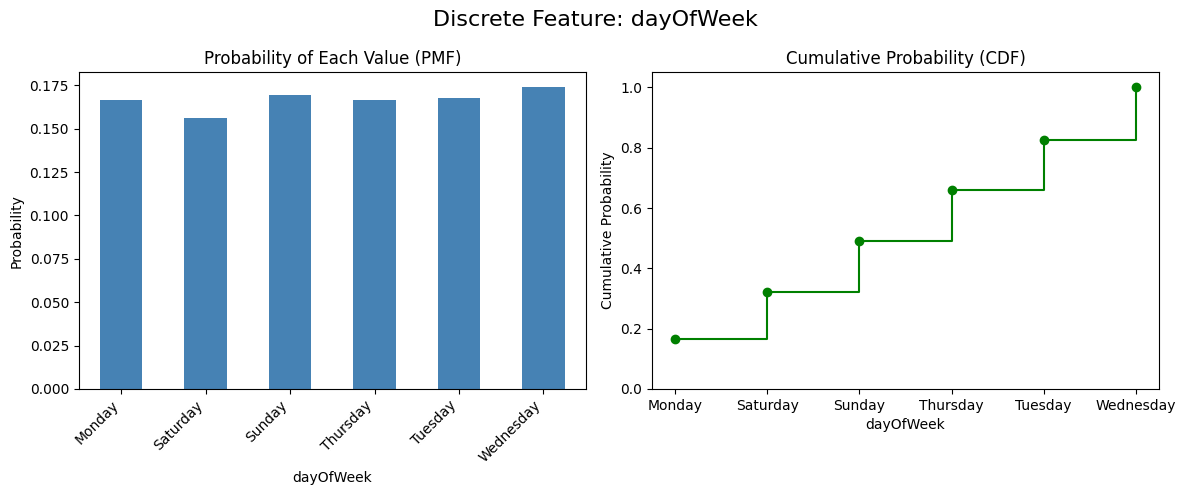

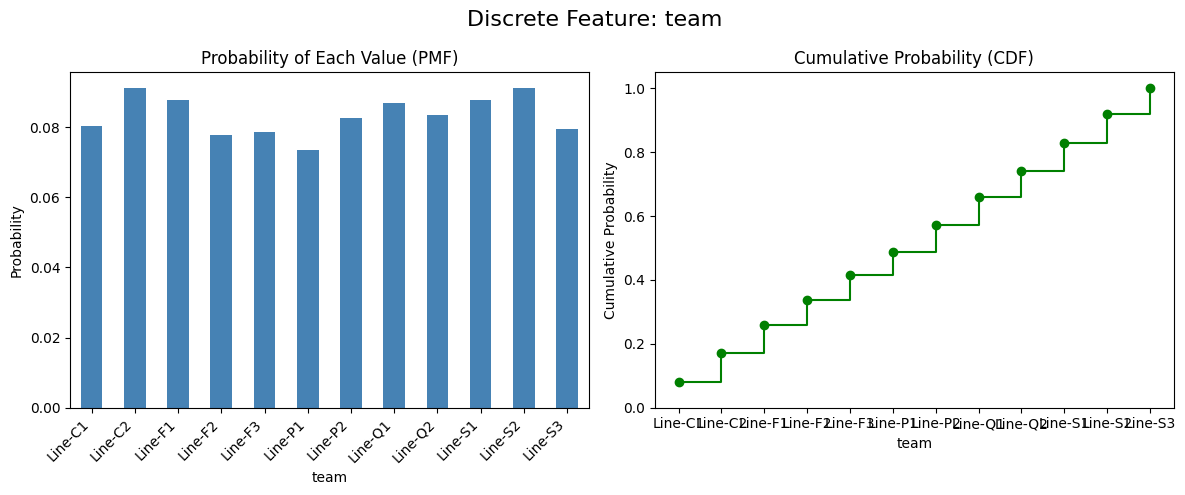

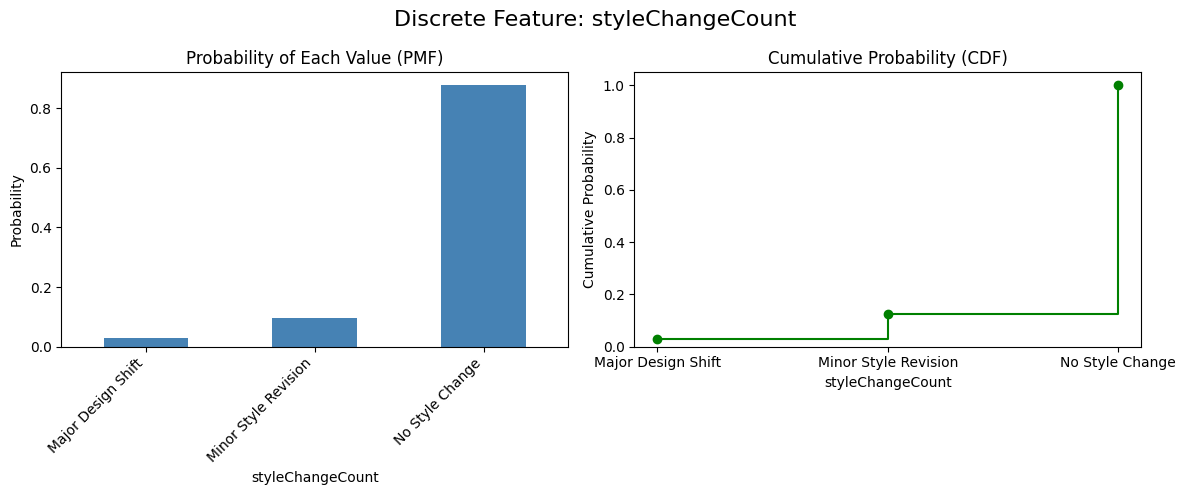

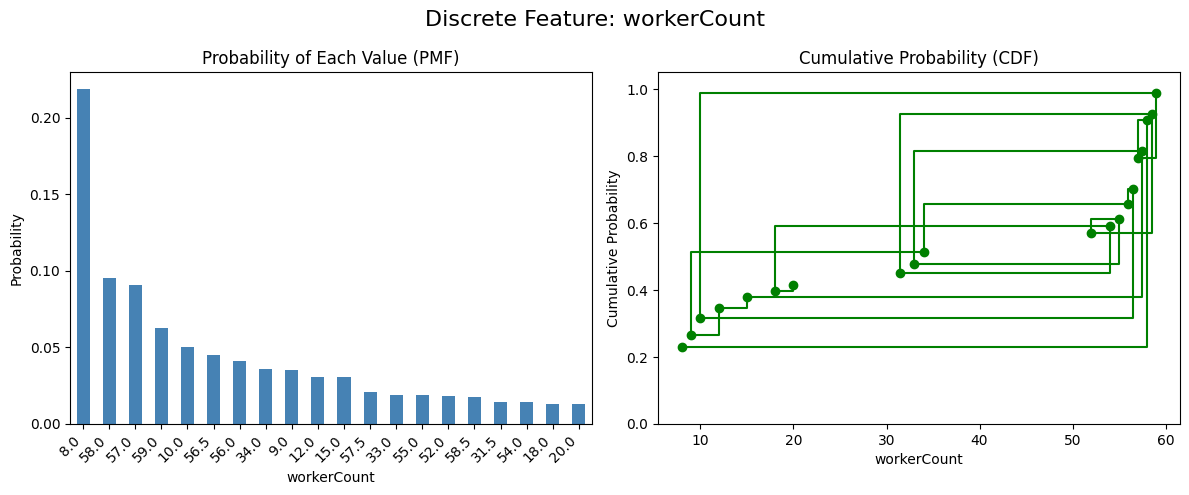

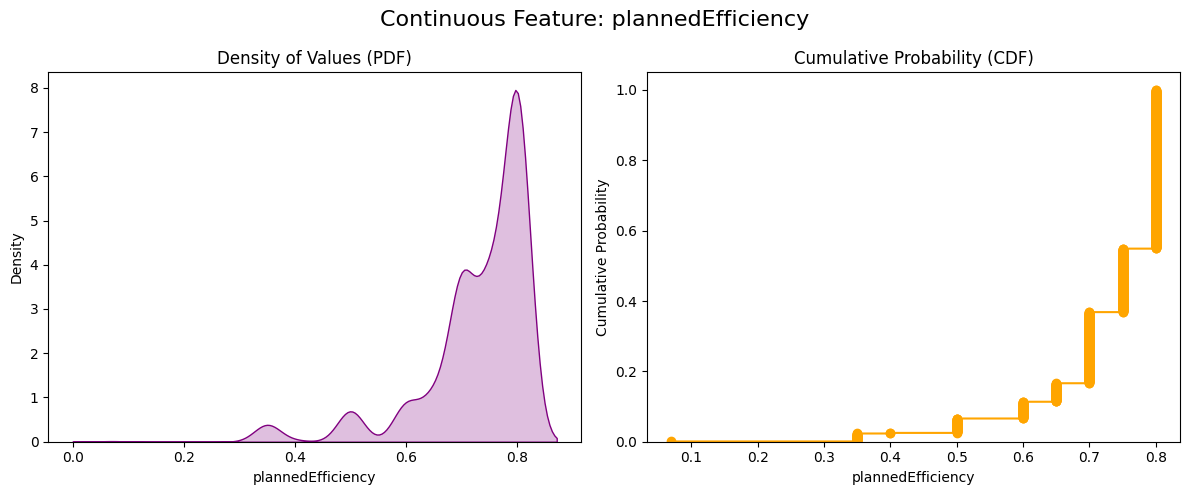

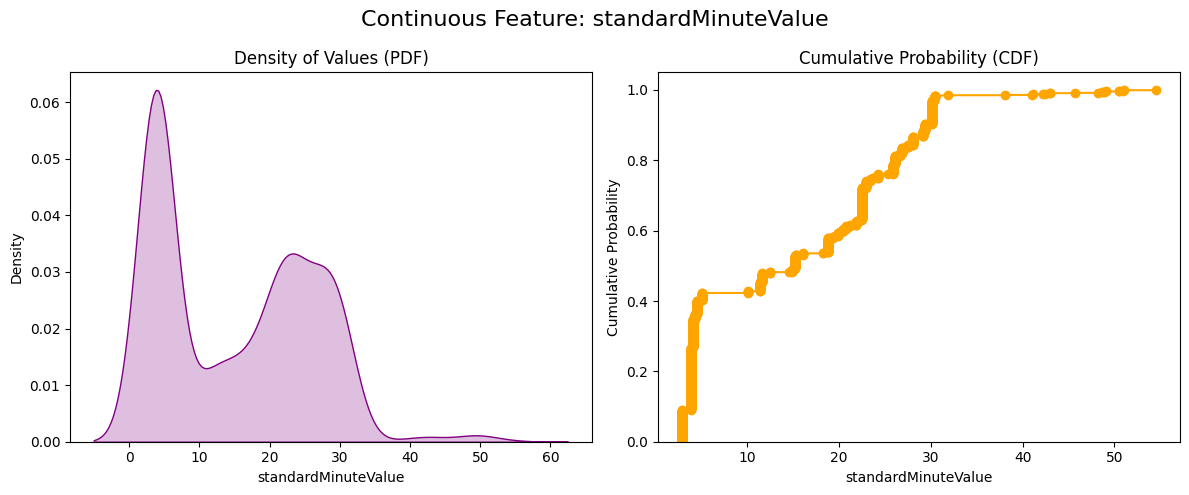

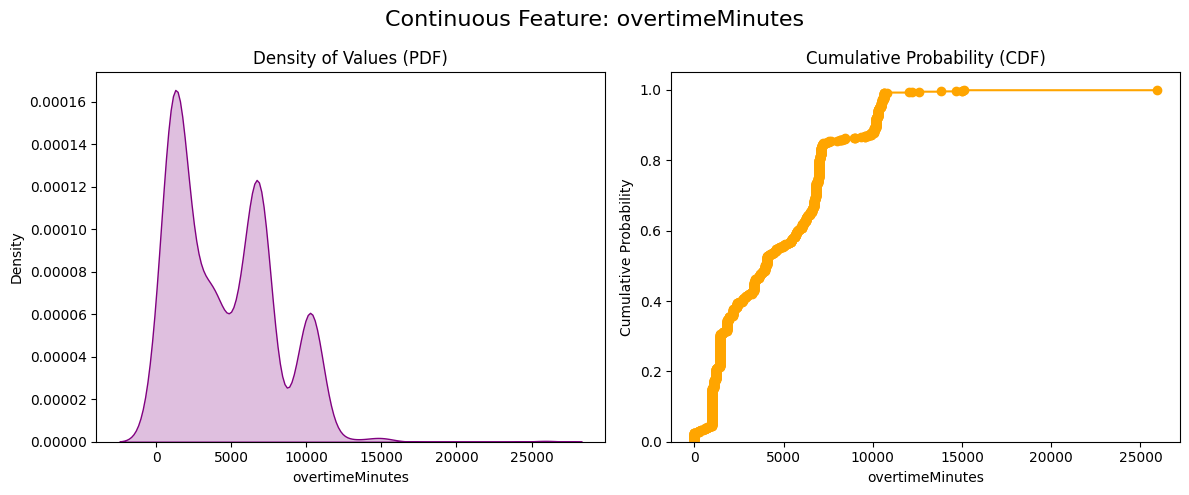

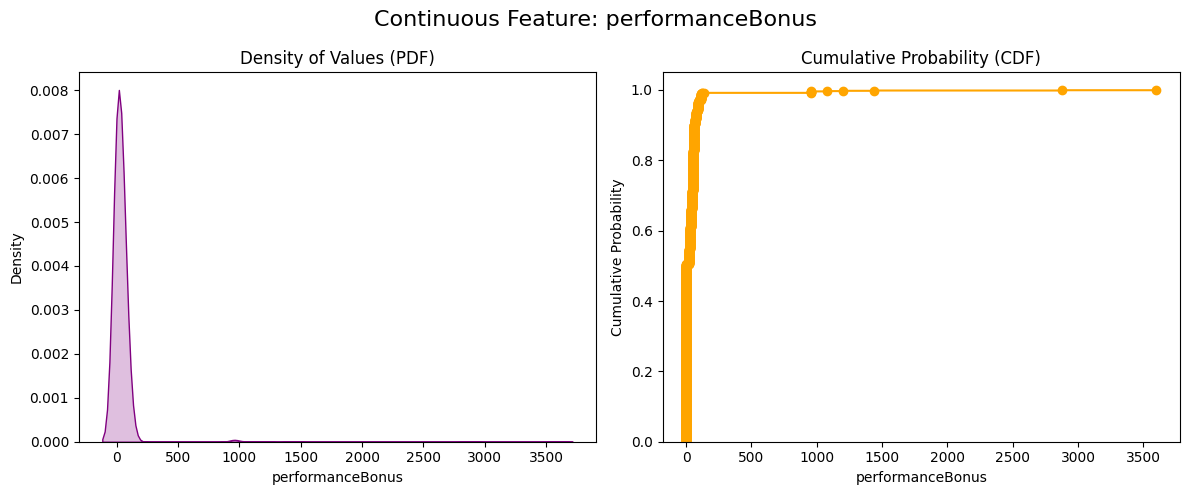

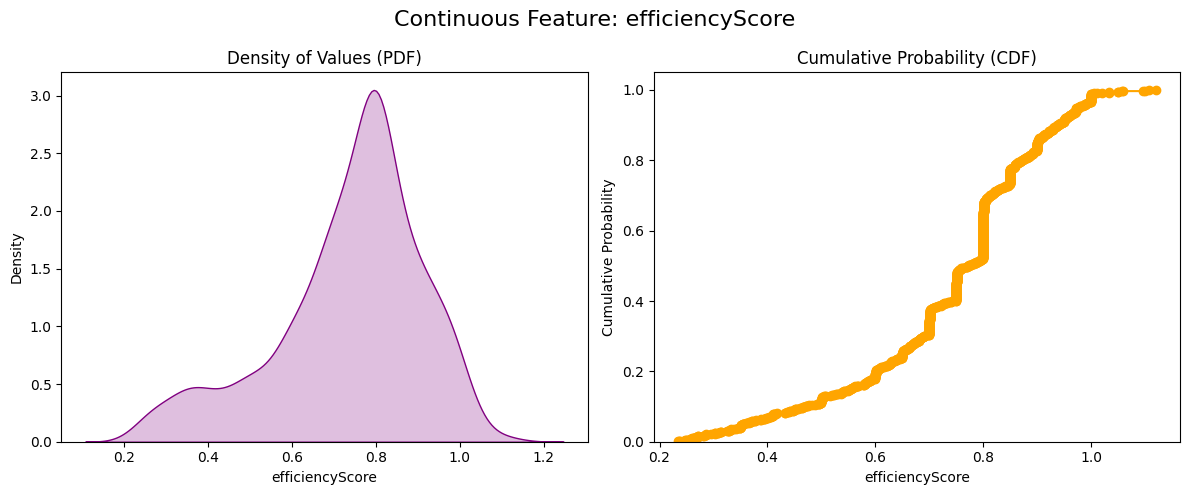

In [93]:
plot_distributions(df, DISCRETE_COLS, CONTINUOUS_COLS)

# QQ plots



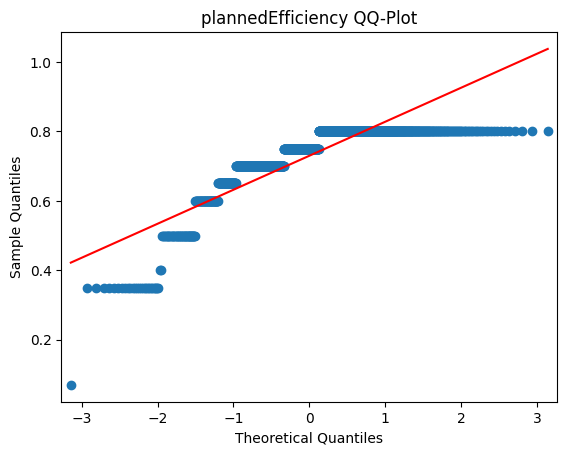

plannedEfficiency interpretation:


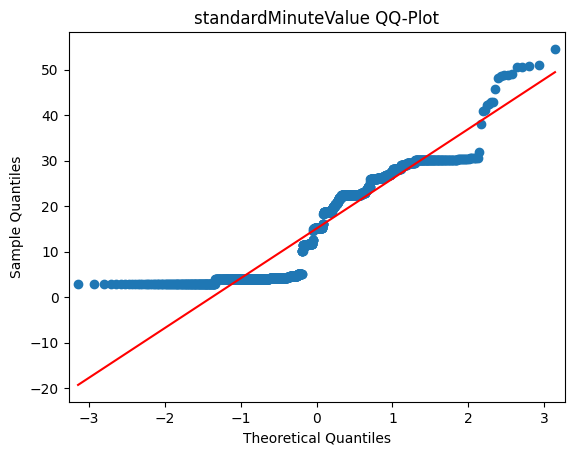

standardMinuteValue interpretation:


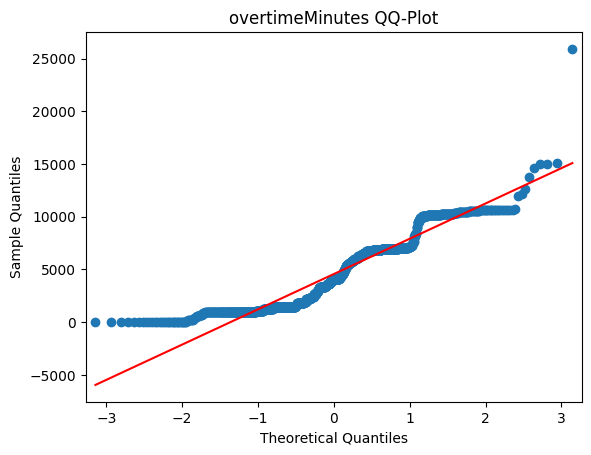

overtimeMinutes interpretation:


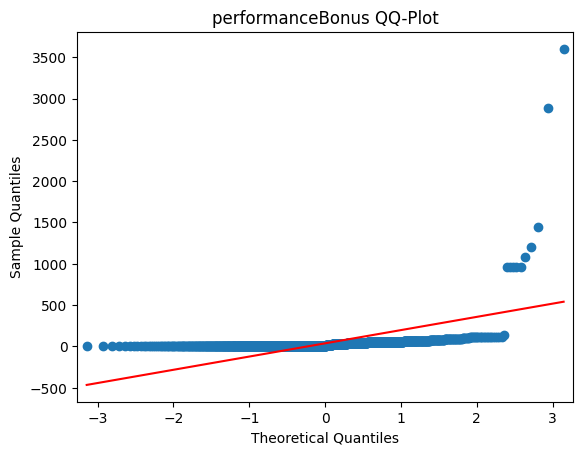

performanceBonus interpretation:


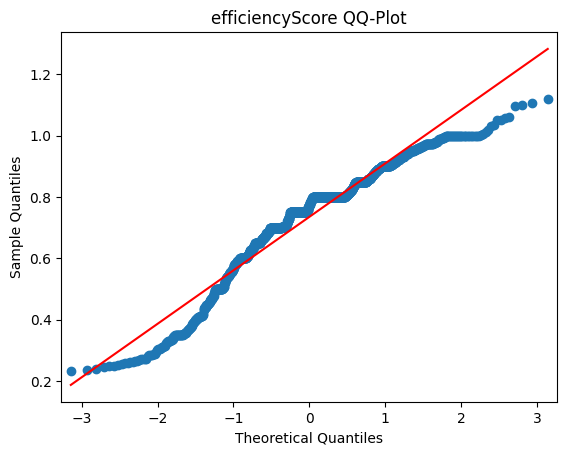

efficiencyScore interpretation:


In [95]:
import statsmodels.api as sm

for col in CONTINUOUS_COLS:
    data = df[col].dropna()
    sm.qqplot(data, line='s')
    plt.title(f"{col} QQ-Plot")
    plt.show()
    print(f"{col} interpretation:")

# building models

# linear regression

In [96]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error


In [98]:
linear_regression_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

linear_regression_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['fiscalQuarter',
                                                   'productionDept',
                                                   'dayOfWeek', 'team',
                                                   'styleChangeCount']),
                                                 ('num', StandardScaler(),
                                                  ['plannedEfficiency',
                                                   'standardMinuteValue',
                                                   'overtimeMinutes',
                                                   'performanceBonus',
                                                   'workerCount'])])),
                ('model', LinearRegression())])

In [99]:
# Predictions
y_pred = linear_regression_pipeline.predict(X_test)

# Evaluation metrics
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Linear Regression Model Performance:")
print(f"R² Score: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")

Linear Regression Model Performance:
R² Score: 0.3518
MSE: 0.0208
RMSE: 0.1444


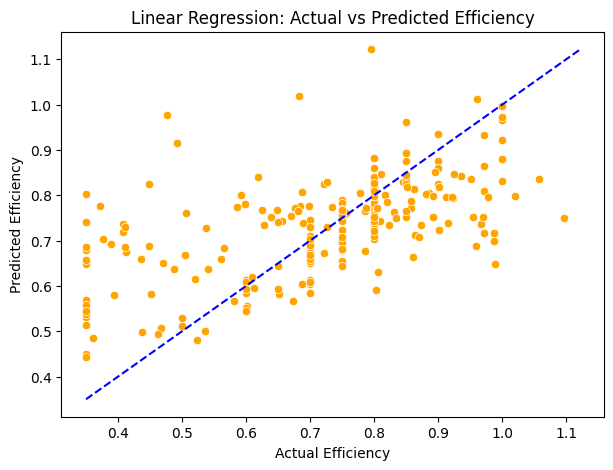

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7,5))
sns.scatterplot(x=y_test, y=y_pred, color='orange')
plt.xlabel("Actual Efficiency")
plt.ylabel("Predicted Efficiency")
plt.title("Linear Regression: Actual vs Predicted Efficiency")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'b--')  # diagonal line
plt.show()


# Decision tree

In [101]:
from sklearn.tree import DecisionTreeRegressor

dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor(random_state=42))
])

dt_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['fiscalQuarter',
                                                   'productionDept',
                                                   'dayOfWeek', 'team',
                                                   'styleChangeCount']),
                                                 ('num', StandardScaler(),
                                                  ['plannedEfficiency',
                                                   'standardMinuteValue',
                                                   'overtimeMinutes',
                                                   'performanceBonus',
                                                   'workerCount'])])),
                ('model', DecisionTreeRegressor(random_state=42))])

In [102]:
y_pred_dt = dt_pipeline.predict(X_test)

# Evaluate
r2 = r2_score(y_test, y_pred_dt)
mse = mean_squared_error(y_test, y_pred_dt)
rmse = np.sqrt(mse)

print("Decision Tree Regression Model Performance:")
print(f"R² Score: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")

Decision Tree Regression Model Performance:
R² Score: 0.2263
MSE: 0.0249
RMSE: 0.1577


# Random forest

In [103]:
from sklearn.ensemble import RandomForestRegressor

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

# Fit the model
rf_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['fiscalQuarter',
                                                   'productionDept',
                                                   'dayOfWeek', 'team',
                                                   'styleChangeCount']),
                                                 ('num', StandardScaler(),
                                                  ['plannedEfficiency',
                                                   'standardMinuteValue',
                                                   'overtimeMinutes',
                                                   'performanceBonus',
                                                   'workerCount'])])),
                ('model', RandomForestRegressor(random_state=42))])

In [104]:

y_pred = rf_pipeline.predict(X_test)


r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Random Forest Regression Results:")
print(f"R² Score: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")


Random Forest Regression Results:
R² Score: 0.5066
MSE: 0.0159
RMSE: 0.1260


In [106]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Build pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

# Define parameter grid
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['auto', 'sqrt']
}

# Initialize GridSearch
grid_search = GridSearchCV(
    rf_pipeline,
    param_grid,
    cv=3,
    n_jobs=-1,
    scoring='r2',
    verbose=2
)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Best parameters and model
print("Best Parameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_

# Predict on test set
y_pred = best_model.predict(X_test)

# Evaluate performance
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Random Forest (Tuned) Performance:")
print(f"R² Score: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")


Fitting 3 folds for each of 216 candidates, totalling 648 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning:


324 fits failed out of a total of 648.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
145 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, 

Best Parameters: {'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 200}
Random Forest (Tuned) Performance:
R² Score: 0.5145
MSE: 0.0156
RMSE: 0.1249


In [107]:
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42, max_depth=20, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=200))
])

# Fit the model
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['fiscalQuarter',
                                                   'productionDept',
                                                   'dayOfWeek', 'team',
                                                   'styleChangeCount']),
                                                 ('num', StandardScaler(),
                                                  ['plannedEfficiency',
                                                   'standardMinuteValue',
                                                   'overtimeMinutes',
                                                   'performanceBonus',
                                                   'workerCount'])])),
                ('model',
                 RandomForestRegressor(max_depth=20, max_features='sqrt',
                                       n_estimators=200, random_state=42))])

In [108]:

y_pred = rf_pipeline.predict(X_test)


r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Random Forest Regression Results:")
print(f"R² Score: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")


Random Forest Regression Results:
R² Score: 0.5145
MSE: 0.0156
RMSE: 0.1249
